In [42]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from forex_python.converter import CurrencyRates
from pypfopt import EfficientFrontier, plotting
import math
import scipy.optimize as sco

## Actual portfolio

In [2]:
portfolio = ['ECOPETROL.CL', 'GEB.CL', 'PFCIBEST.CL', 'CIBEST.CL', 'GOOGL', 'AAPL', 'BVC.CL', 'NKE','IVV']

In [3]:
stock_prices = pd.DataFrame()
stock_returns = pd.DataFrame()

today_date = datetime.now()
end = today_date.strftime('%Y-%m-%d')

for x in portfolio:
    stock = yf.Ticker(x)
    close_price = stock.history(start='2021-01-01', end=end)['Close']

    stock_prices = pd.concat([stock_prices, close_price], axis=1)

    stock_returns = pd.concat([stock_returns, close_price.pct_change()], axis=1)

stock_prices.columns = portfolio
stock_returns.columns = portfolio

stock_prices = stock_prices.dropna()
stock_returns = stock_returns.dropna()

In [4]:
# Descargar el histórico del dólar (USD a COP)
usd_cop = yf.Ticker("COP=X").history(start='2021-01-01', end=end)['Close']

# Asegurar que los índices coincidan con tus stock_prices
usd_cop = usd_cop.reindex(stock_prices.index, method='ffill')

In [5]:
# Lista de tickers que están en USD y quieres pasar a COP
stocks_en_usd = ['AAPL', 'IVV', 'GOOGL', 'NKE'] # Ajusta según tu caso

# Aplicar la conversión solo a esas columnas
for ticker in stocks_en_usd:
    if ticker in stock_prices.columns:
        stock_prices[ticker] = stock_prices[ticker] * usd_cop

In [6]:
stock_prices.head()

,ECOPETROL.CL,GEB.CL,PFCIBEST.CL,CIBEST.CL,GOOGL,AAPL,BVC.CL,NKE,IVV
2021-01-04 00:00:00-05:00,1157.895508,1699.219116,21898.806641,22459.771484,292976.200743,430864.109732,7506.621582,446224.051880,1.179055e+06
2021-01-05 00:00:00-05:00,1183.718262,1715.099976,21905.248047,23914.625000,297713.417673,439698.392395,7557.257812,453439.729980,1.196400e+06
2021-01-06 00:00:00-05:00,1191.981689,1708.747314,22001.890625,22862.037109,294305.520544,424219.678648,7557.257812,456306.700054,1.201704e+06
2021-01-07 00:00:00-05:00,1225.551270,1626.803833,22240.269531,23002.830078,300502.861099,434942.114023,7772.455566,460665.880883,1.209060e+06
2021-01-08 00:00:00-05:00,1238.979126,1628.074585,22401.339844,23532.480469,311211.727713,448393.727331,8038.288574,475396.503086,1.242834e+06


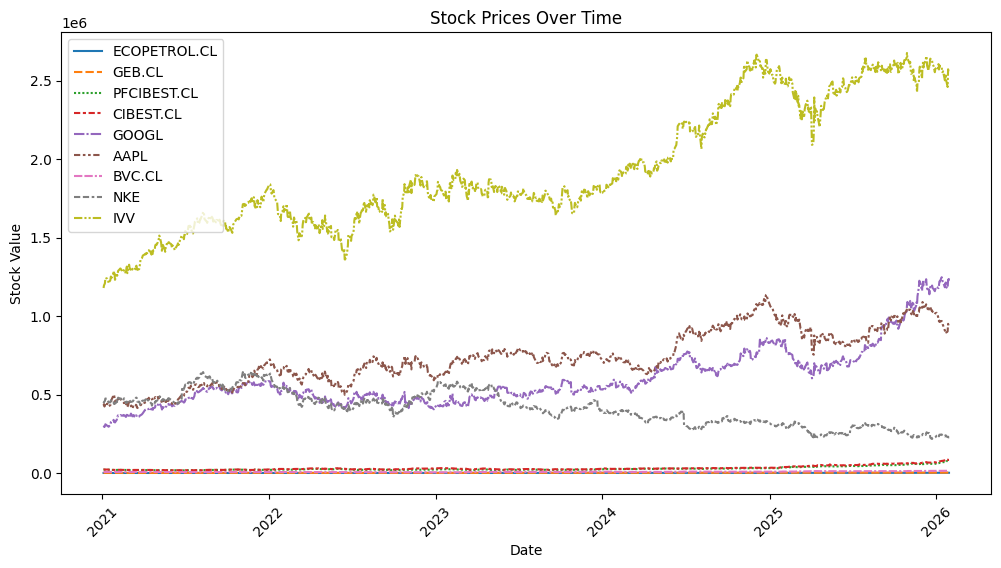

In [7]:
plt.figure(figsize=(12,6))

sns.lineplot(data=stock_prices)

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Value')
plt.title('Stock Prices Over Time')
plt.savefig('stock_prices_over_time.png')
plt.show()

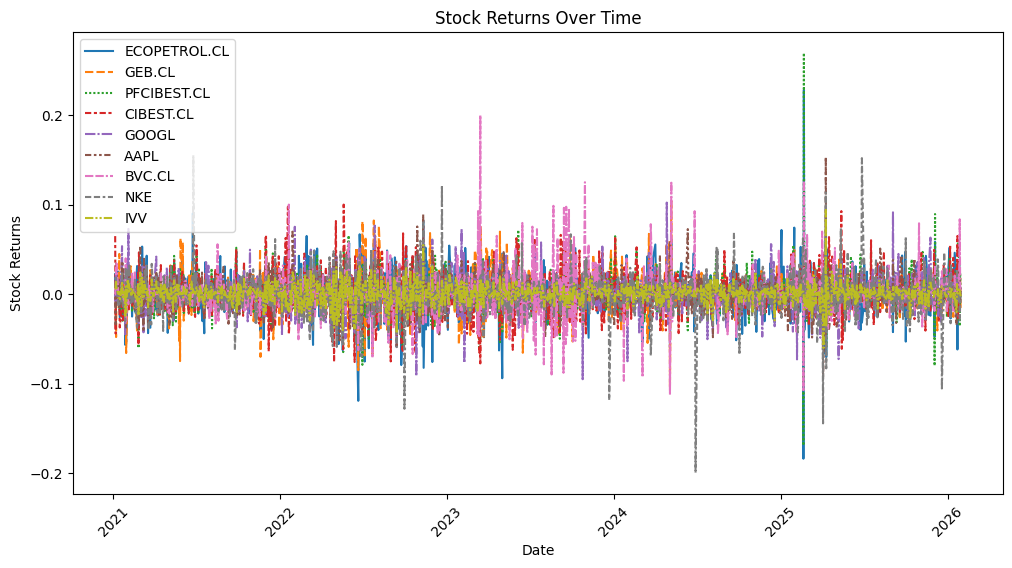

In [8]:
plt.figure(figsize=(12,6))

sns.lineplot(data=stock_returns)

plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Stock Returns')
plt.title('Stock Returns Over Time')
plt.savefig('stock_returns_over_time.png')
plt.show()

In [9]:
expected_stock_returns = []
individual_stock_risk = []

for x, y in stock_returns.items():
    expected_stock_returns.append(y.mean())

    individual_stock_risk.append(y.std())

In [10]:
print(f"Mean return (percent)")

for name, value in zip(portfolio, expected_stock_returns):
    print(f"\t{name}: \t{value}%")

Mean return (percent)
	ECOPETROL.CL: 	0.0007816199363697066%
	GEB.CL: 	0.0006427475881728371%
	PFCIBEST.CL: 	0.0012863631106060527%
	CIBEST.CL: 	0.0013883646336852982%
	GOOGL: 	0.001119046952937947%
	AAPL: 	0.000539222008273103%
	BVC.CL: 	0.0009271148938680637%
	NKE: 	-0.00038934257959604486%
	IVV: 	0.0004926343743754784%


In [11]:
print(f"Risk (Std. Dev)")

for name, value in zip(portfolio, individual_stock_risk):
    print(f"\t{name}: \t{value}")

Risk (Std. Dev)
	ECOPETROL.CL: 	0.023301015317219367
	GEB.CL: 	0.019111601765167234
	PFCIBEST.CL: 	0.01996401669667486
	CIBEST.CL: 	0.02160608261622836
	GOOGL: 	0.0197444232096448
	AAPL: 	0.017704124960709174
	BVC.CL: 	0.021658177101954505
	NKE: 	0.022114828480345138
	IVV: 	0.010793797007840692


In [12]:
expected_stock_returns = np.array(pd.DataFrame(expected_stock_returns))
individual_stock_risk = np.array(pd.DataFrame(individual_stock_risk))

stock_returns_cov_matrix = np.array(stock_returns.cov())

In [13]:
stock_returns_cov_matrix

array([[ 5.42937315e-04,  1.11339603e-04,  2.28484975e-04,
         1.10239469e-04,  5.19614884e-05,  6.57025757e-05,
         7.99119976e-05,  8.32195535e-05,  5.76876667e-05],
       [ 1.11339603e-04,  3.65253322e-04,  7.70459871e-05,
         5.31287418e-05,  2.97637735e-05,  1.97959673e-05,
         6.95086964e-05,  3.81028440e-05,  2.98228151e-05],
       [ 2.28484975e-04,  7.70459871e-05,  3.98561963e-04,
         2.23653630e-04,  5.06955749e-05,  5.79601963e-05,
         7.93209524e-05,  7.17787679e-05,  5.13482082e-05],
       [ 1.10239469e-04,  5.31287418e-05,  2.23653630e-04,
         4.66822806e-04,  3.19482348e-05,  2.45424807e-05,
        -1.36246430e-05,  4.13486502e-05,  3.18859644e-05],
       [ 5.19614884e-05,  2.97637735e-05,  5.06955749e-05,
         3.19482348e-05,  3.89842248e-04,  2.05568534e-04,
         3.21872686e-05,  1.59069622e-04,  1.47450869e-04],
       [ 6.57025757e-05,  1.97959673e-05,  5.79601963e-05,
         2.45424807e-05,  2.05568534e-04,  3.134360

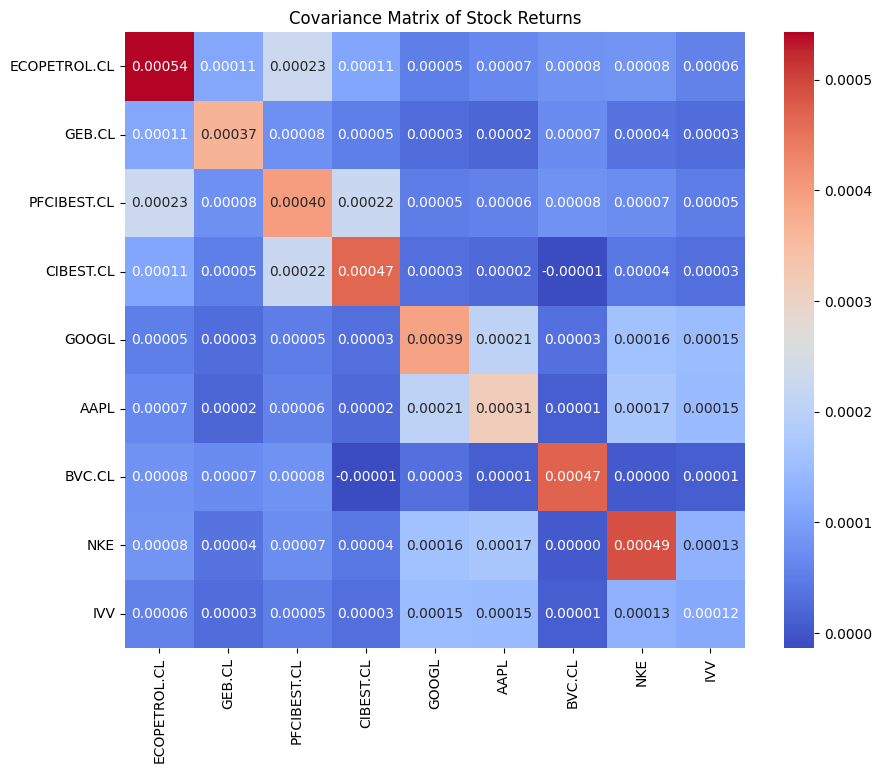

In [41]:
cov_matrix_df = stock_returns.cov()

plt.figure(figsize=(10,8))

sns.heatmap(cov_matrix_df, annot=True, fmt=".5f", cmap='coolwarm')

plt.title('Covariance Matrix of Stock Returns')
plt.savefig('covariance_matrix_stock_returns.png')
plt.show()

In [17]:
cov_matrix_df

,ECOPETROL.CL,GEB.CL,PFCIBEST.CL,CIBEST.CL,GOOGL,AAPL,BVC.CL,NKE,IVV
ECOPETROL.CL,0.000544,0.000111,0.000229,0.000111,0.000052,0.000065,0.000079,0.000084,0.000058
GEB.CL,0.000111,0.000366,0.000077,0.000054,0.000030,0.000020,0.000069,0.000039,0.000030
PFCIBEST.CL,0.000229,0.000077,0.000397,0.000224,0.000051,0.000058,0.000081,0.000071,0.000051
CIBEST.CL,0.000111,0.000054,0.000224,0.000468,0.000032,0.000025,-0.000012,0.000041,0.000032
GOOGL,0.000052,0.000030,0.000051,0.000032,0.000391,0.000206,0.000032,0.000160,0.000148
AAPL,0.000065,0.000020,0.000058,0.000025,0.000206,0.000314,0.000008,0.000174,0.000146
BVC.CL,0.000079,0.000069,0.000081,-0.000012,0.000032,0.000008,0.000464,0.000007,0.000008
NKE,0.000084,0.000039,0.000071,0.000041,0.000160,0.000174,0.000007,0.000490,0.000130
IVV,0.000058,0.000030,0.000051,0.000032,0.000148,0.000146,0.000008,0.000130,0.000117


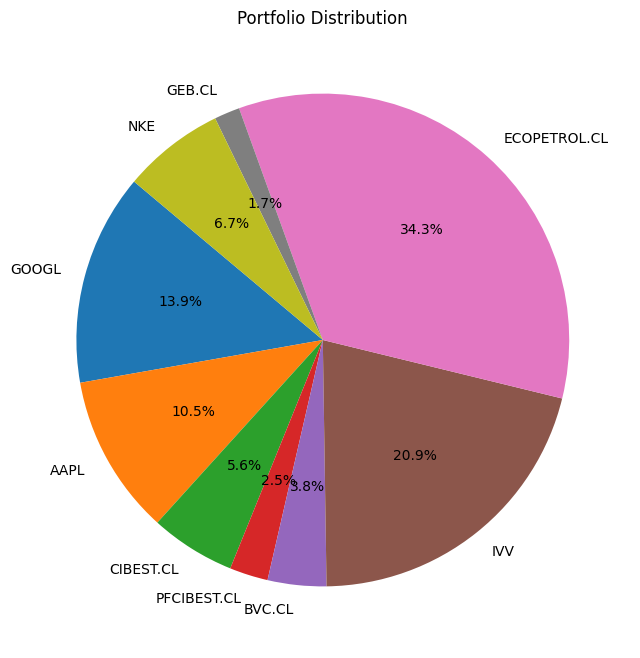

In [18]:
# 1. Definición de activos y cantidades (Excluyendo IUIT)
portfolio_data = {
    "GOOGL": 7,
    "AAPL": 7,
    "CIBEST.CL": 39,
    "PFCIBEST.CL": 20,
    "BVC.CL": 154,
    "IVV": 5,
    "ECOPETROL.CL": 9006,
    "GEB.CL": 308,
    "NKE": 17
}

# 2. Selección del último día de precios
# Asumiendo que 'df_precios' es tu DataFrame con las series de tiempo
last_prices = stock_prices.iloc[-1]

# 3. Cálculo del valor actual y pesos
portfolio_values = {ticker: last_prices[ticker] * qty for ticker, qty in portfolio_data.items()}
total_value = sum(portfolio_values.values())
weights = {ticker: val / total_value for ticker, val in portfolio_values.items()}

#Pie plot of portfolio distribution
plt.figure(figsize=(8,8))
plt.pie(weights.values(), labels=weights.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Portfolio Distribution')
plt.show()

In [20]:
ef = EfficientFrontier(expected_stock_returns, cov_matrix_df, weight_bounds=(0,1))
ratios = ef.min_volatility()
cleaned_ratios = pd.Series(ratios)
cleaned_ratios.index = portfolio

optimal_portfolio = np.expand_dims(cleaned_ratios, axis=0)

# Rendimiento esperado
opt_portfolio_expected_return = np.matmul(optimal_portfolio, expected_stock_returns)

# Varianza del portafolio
opt_portfolio_var = np.matmul(optimal_portfolio, \
                              np.matmul(stock_returns_cov_matrix, optimal_portfolio.transpose()))

# Riesgo del portafolio
opt_portfolio_risk = math.sqrt(opt_portfolio_var)

# Ver datos obtenidos y Portafolio Óptimo de Markowitz:
print('PORTAFOLIO ÓPTIMO DE MARKOWITZ:')
print(f'Rendimiento esperado: {opt_portfolio_expected_return*100}')
print(f'Varianza del portafolio: {opt_portfolio_var*100}')
print(f'Riesgo del portafolio: {opt_portfolio_risk*100}')

print('\n\nDel 100% de tu capital, el modelo sugiere\
invertir las siguientes proporciones en cada activo:')
display(cleaned_ratios*100)
     


PORTAFOLIO ÓPTIMO DE MARKOWITZ:
Rendimiento esperado: [[0.06634499]]
Varianza del portafolio: [[0.00799033]]
Riesgo del portafolio: 0.8938863854003218


Del 100% de tu capital, el modelo sugiereinvertir las siguientes proporciones en cada activo:


C:\Users\jaayg\AppData\Local\Temp\ipykernel_11236\1680248768.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  opt_portfolio_risk = math.sqrt(opt_portfolio_var)


ECOPETROL.CL     1.317784
GEB.CL          12.103881
PFCIBEST.CL      0.000000
CIBEST.CL       11.612843
GOOGL            0.000000
AAPL             0.000000
BVC.CL          14.485683
NKE              0.000000
IVV             60.479808
dtype: float64

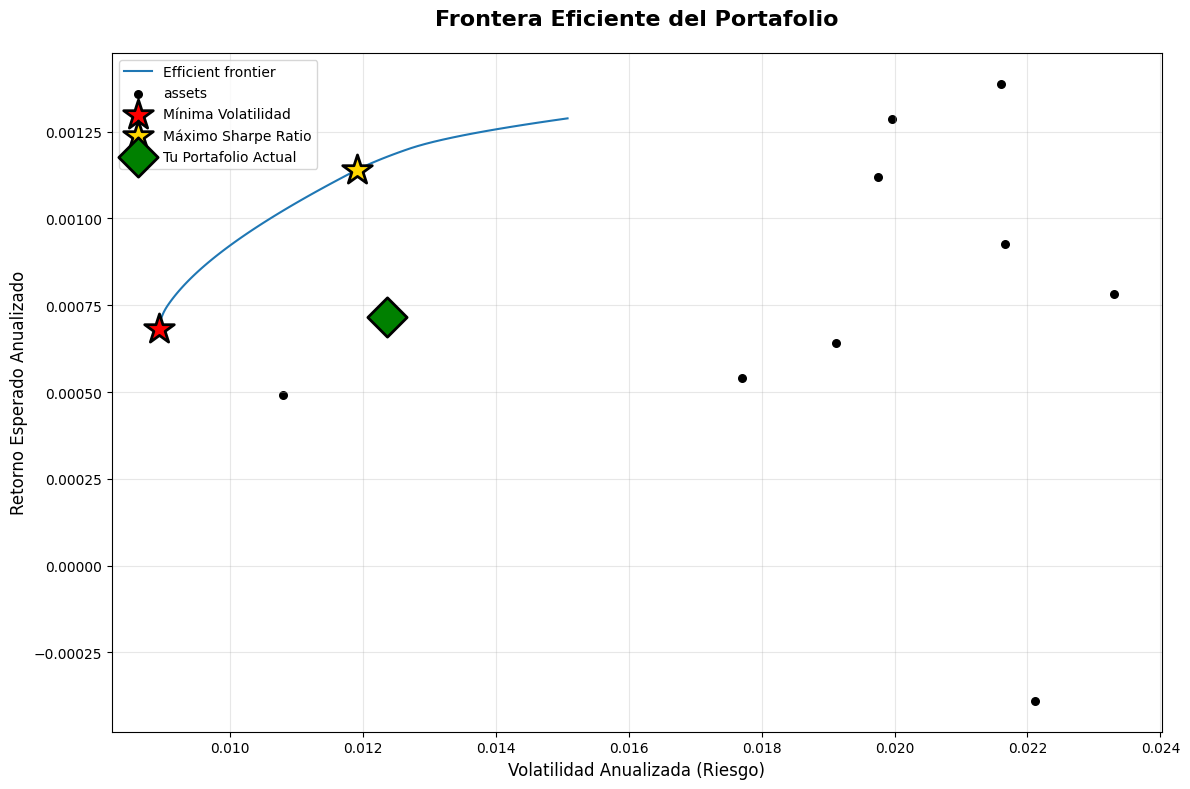

In [ ]:
# Crear la frontera eficiente inicial para graficar
ef = EfficientFrontier(expected_stock_returns, cov_matrix_df, weight_bounds=(0, 1))

# Crear figura
fig, ax = plt.subplots(figsize=(12, 8))

# Graficar la frontera eficiente
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# 1. Portafolio de mínima volatilidad
ef_min_vol = EfficientFrontier(expected_stock_returns, cov_matrix_df, weight_bounds=(0, 1))
ef_min_vol.min_volatility()
ret_min_vol, std_min_vol, _ = ef_min_vol.portfolio_performance()
ax.scatter(std_min_vol, ret_min_vol, marker='*', s=500, c='red', 
           label='Mínima Volatilidad', edgecolors='black', linewidths=2, zorder=3)

# 2. Portafolio de máximo Sharpe Ratio
ef_max_sharpe = EfficientFrontier(expected_stock_returns, cov_matrix_df, weight_bounds=(0, 1))
ef_max_sharpe.max_sharpe()
ret_max_sharpe, std_max_sharpe, _ = ef_max_sharpe.portfolio_performance()
ax.scatter(std_max_sharpe, ret_max_sharpe, marker='*', s=500, c='gold', 
           label='Máximo Sharpe Ratio', edgecolors='black', linewidths=2, zorder=3)

# 3. Tu portafolio actual
if weights is not None:
    # Convertir pesos a array en el orden correcto
    weights_array = np.array([weights.get(ticker, 0) for ticker in stock_returns.columns])
    
    # Calcular retorno esperado del portafolio
    ret_actual = np.dot(weights_array, expected_stock_returns)
    
    # Calcular volatilidad del portafolio
    std_actual = np.sqrt(np.dot(weights_array, np.dot(cov_matrix_df, weights_array)))
    
    ax.scatter(std_actual, ret_actual, marker='D', s=400, c='green', 
               label='Tu Portafolio Actual', edgecolors='black', linewidths=2, zorder=3)

# Configurar el gráfico
ax.set_title('Frontera Eficiente del Portafolio', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Volatilidad Anualizada (Riesgo)', fontsize=12)
ax.set_ylabel('Retorno Esperado Anualizado', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('frontera_eficiente.png', dpi=300, bbox_inches='tight')
plt.show()

## Portfolio simulation

In [15]:
portfolio = ['ECOPETROL.CL', 'GEB.CL', 'PFCIBEST.CL', 'CIBEST.CL', 'GOOGL', 'AAPL', 'BVC.CL', 'NKE','IVV']

In [16]:
# Lista de tickers que están en USD y quieres pasar a COP
stocks_en_usd = ['AAPL', 'IVV', 'GOOGL', 'NKE'] # Ajusta según tu caso

In [17]:
def calcular_pesos_minima_volatilidad(returns):
    """
    Calcula los pesos óptimos usando mínima volatilidad
    """
    expected_returns = returns.mean()
    cov_matrix = returns.cov()
    
    ef = EfficientFrontier(expected_returns, cov_matrix, weight_bounds=(0,1))
    pesos = ef.min_volatility()
    
    return pd.Series(pesos)

In [18]:
def descargar_precios(portfolio, start_date, end_date, stocks_en_usd):
    """
    Descarga precios y convierte USD a COP
    """
    stock_prices = pd.DataFrame()
    
    # Descargar precios de acciones
    for ticker in portfolio:
        stock = yf.Ticker(ticker)
        close_price = stock.history(start=start_date, end=end_date)['Close']
        stock_prices = pd.concat([stock_prices, close_price], axis=1)
    
    stock_prices.columns = portfolio
    
    # Descargar tipo de cambio USD/COP
    usd_cop = yf.Ticker("COP=X").history(start=start_date, end=end_date)['Close']
    usd_cop = usd_cop.reindex(stock_prices.index, method='ffill')
    
    # Convertir acciones en USD a COP
    for ticker in stocks_en_usd:
        if ticker in stock_prices.columns:
            stock_prices[ticker] = stock_prices[ticker] * usd_cop
    
    stock_prices = stock_prices.dropna()
    
    return stock_prices

In [19]:
def backtest_rebalanceo(portfolio, stocks_en_usd, fecha_inicio_entrenamiento, 
                        fecha_inicio_backtest, fecha_fin_backtest, 
                        meses_rebalanceo, inversion_inicial=10000000):
    """
    Realiza backtesting con rebalanceo periódico
    
    Parámetros:
    - meses_rebalanceo: 3 (trimestral), 6 (semestral), 12 (anual)
    - inversion_inicial: capital inicial en COP
    """
    
    # Descargar datos de entrenamiento
    precios_entrenamiento = descargar_precios(
        portfolio, 
        fecha_inicio_entrenamiento, 
        fecha_inicio_backtest,
        stocks_en_usd
    )
    
    # Descargar datos de backtest
    precios_backtest = descargar_precios(
        portfolio,
        fecha_inicio_backtest,
        fecha_fin_backtest,
        stocks_en_usd
    )
    
    # Calcular retornos para entrenamiento inicial
    retornos_entrenamiento = precios_entrenamiento.pct_change().dropna()
    
    # Calcular pesos iniciales
    pesos_actuales = calcular_pesos_minima_volatilidad(retornos_entrenamiento)
    
    # Inicializar portafolio
    valor_portafolio = [inversion_inicial]
    fechas_rebalanceo = [precios_backtest.index[0]]
    historial_pesos = [pesos_actuales.to_dict()]
    
    # Variables para tracking
    ultima_fecha_rebalanceo = precios_backtest.index[0]
    precio_inicial = precios_backtest.iloc[0]
    acciones = (pesos_actuales * inversion_inicial) / precio_inicial
    
    # Iterar sobre cada día del período de backtest
    for i in range(1, len(precios_backtest)):
        fecha_actual = precios_backtest.index[i]
        precios_actual = precios_backtest.iloc[i]
        
        # Calcular valor actual del portafolio
        valor_actual = (acciones * precios_actual).sum()
        valor_portafolio.append(valor_actual)
        
        # Verificar si toca rebalancear
        meses_transcurridos = (fecha_actual.year - ultima_fecha_rebalanceo.year) * 12 + \
                              (fecha_actual.month - ultima_fecha_rebalanceo.month)
        
        if meses_transcurridos >= meses_rebalanceo:
            # Actualizar datos de entrenamiento hasta la fecha actual
            precios_entrenamiento_actual = descargar_precios(
                portfolio,
                fecha_inicio_entrenamiento,
                fecha_actual.strftime('%Y-%m-%d'),
                stocks_en_usd
            )
            
            retornos_entrenamiento_actual = precios_entrenamiento_actual.pct_change().dropna()
            
            # Recalcular pesos óptimos
            pesos_actuales = calcular_pesos_minima_volatilidad(retornos_entrenamiento_actual)
            
            # Rebalancear: vender todo y comprar según nuevos pesos
            acciones = (pesos_actuales * valor_actual) / precios_actual
            
            # Guardar información del rebalanceo
            ultima_fecha_rebalanceo = fecha_actual
            fechas_rebalanceo.append(fecha_actual)
            historial_pesos.append(pesos_actuales.to_dict())

    resultados = pd.DataFrame({
        'Valor_Portafolio': valor_portafolio
    }, index=precios_backtest.index)
    
    resultados['Retorno_Acumulado'] = (resultados['Valor_Portafolio'] / inversion_inicial - 1) * 100
    resultados['Retorno_Diario'] = resultados['Valor_Portafolio'].pct_change()
    
    # Métricas de desempeño
    retorno_total = (valor_portafolio[-1] / inversion_inicial - 1) * 100
    retorno_anualizado = ((valor_portafolio[-1] / inversion_inicial) ** 
                          (252 / len(precios_backtest)) - 1) * 100
    volatilidad_anualizada = resultados['Retorno_Diario'].std() * np.sqrt(252) * 100
    sharpe_ratio = retorno_anualizado / volatilidad_anualizada if volatilidad_anualizada > 0 else 0
    
    # Drawdown
    cummax = resultados['Valor_Portafolio'].cummax()
    drawdown = (resultados['Valor_Portafolio'] - cummax) / cummax * 100
    max_drawdown = drawdown.min()
    
    metricas = {
        'Retorno Total (%)': retorno_total,
        'Retorno Anualizado (%)': retorno_anualizado,
        'Volatilidad Anualizada (%)': volatilidad_anualizada,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown (%)': max_drawdown,
        'Num Rebalanceos': len(fechas_rebalanceo) - 1
    }
    
    return resultados, metricas, fechas_rebalanceo, historial_pesos

Ejecutando backtests...

1. REBALANCEO TRIMESTRAL (cada 3 meses)
--------------------------------------------------------------------------------
Retorno Total (%): 133.93
Retorno Anualizado (%): 34.26
Volatilidad Anualizada (%): 17.04
Sharpe Ratio: 2.01
Max Drawdown (%): -11.25
Num Rebalanceos: 12.00

2. REBALANCEO SEMESTRAL (cada 6 meses)
--------------------------------------------------------------------------------
Retorno Total (%): 136.57
Retorno Anualizado (%): 34.78
Volatilidad Anualizada (%): 17.23
Sharpe Ratio: 2.02
Max Drawdown (%): -11.25
Num Rebalanceos: 6.00

3. REBALANCEO ANUAL (cada 12 meses)
--------------------------------------------------------------------------------
Retorno Total (%): 144.97
Retorno Anualizado (%): 36.42
Volatilidad Anualizada (%): 18.66
Sharpe Ratio: 1.95
Max Drawdown (%): -14.01
Num Rebalanceos: 3.00

4. BUY AND HOLD (sin rebalanceo)
--------------------------------------------------------------------------------
Retorno Total (%): 141.50
Retor

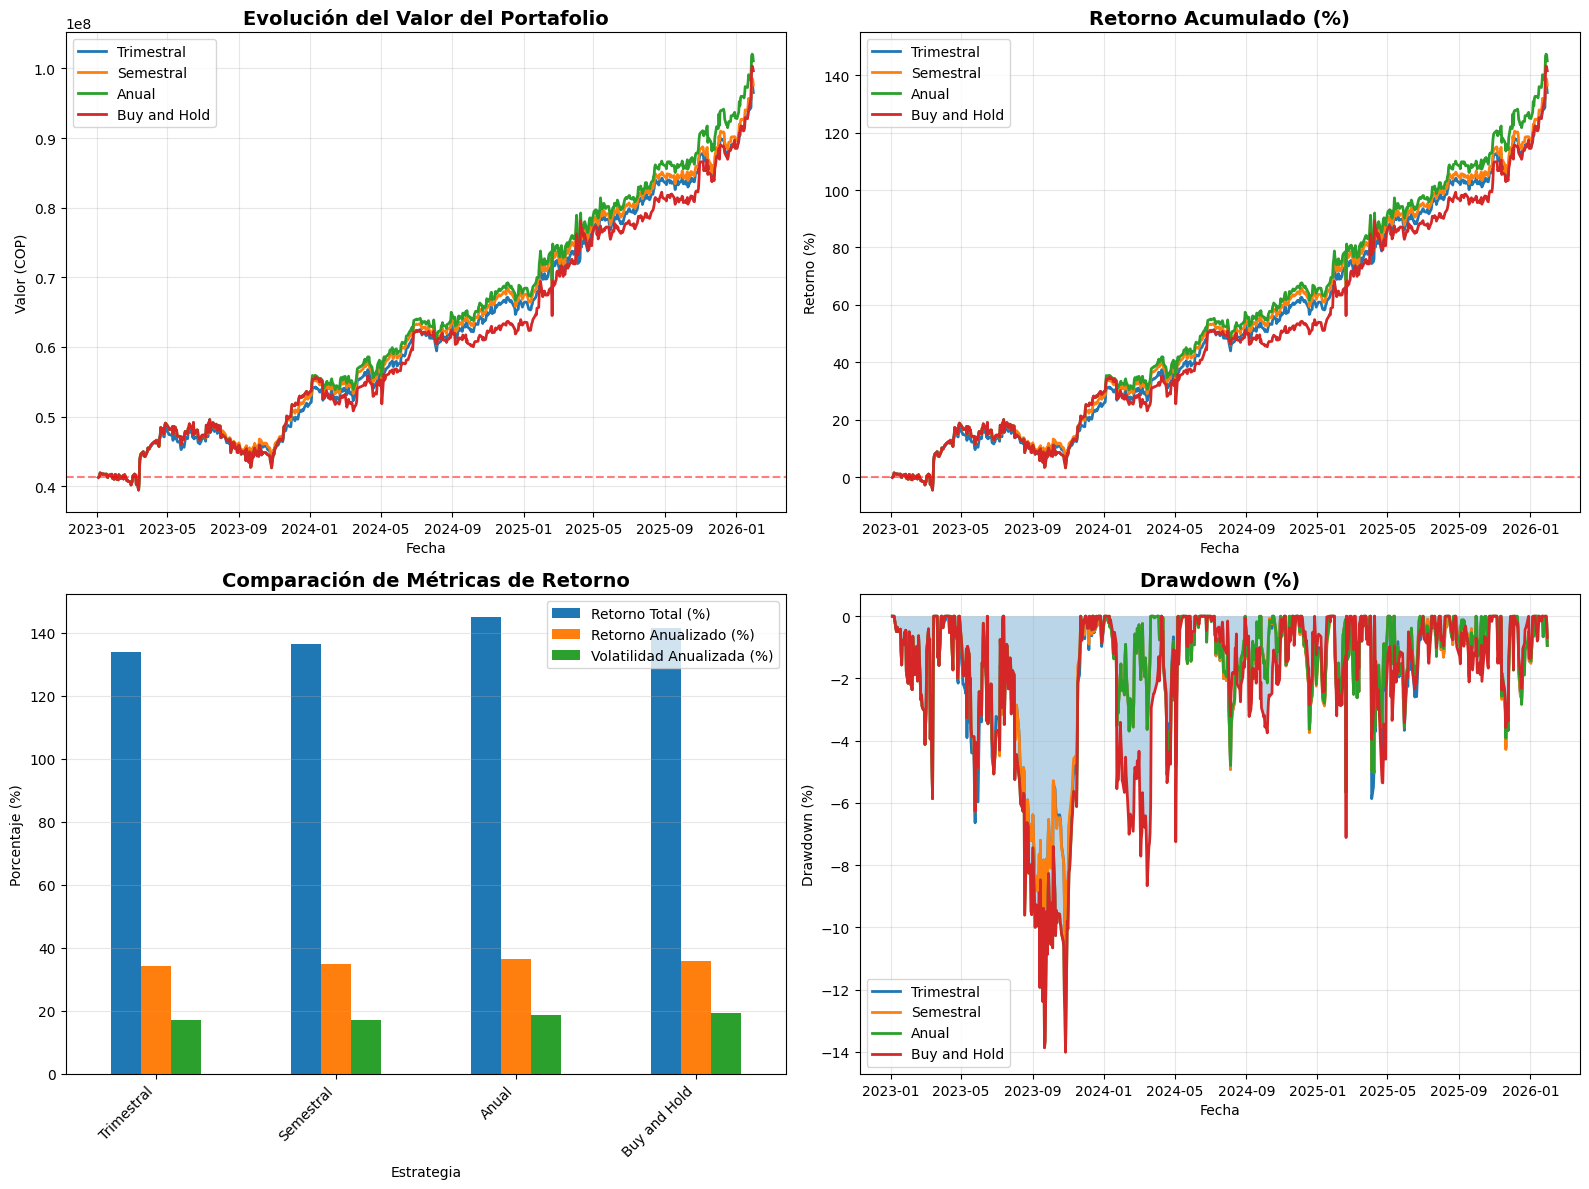


TABLA RESUMEN DE MÉTRICAS
                            Trimestral  Semestral   Anual  Buy and Hold
Retorno Total (%)               133.93     136.57  144.97        141.50
Retorno Anualizado (%)           34.26      34.78   36.42         35.75
Volatilidad Anualizada (%)       17.04      17.23   18.66         19.44
Sharpe Ratio                      2.01       2.02    1.95          1.84
Max Drawdown (%)                -11.25     -11.25  -14.01        -14.01
Num Rebalanceos                  12.00       6.00    3.00          0.00


In [35]:
# EJECUTAR BACKTESTS CON DIFERENTES FRECUENCIAS
print("Ejecutando backtests...")
print("=" * 80)

# Parámetros
fecha_inicio_entrenamiento = '2021-01-01'
fecha_inicio_backtest = '2023-01-01'
fecha_fin_backtest = datetime.now().strftime('%Y-%m-%d')
inversion_inicial = 41267106  # 41,267,106 COP

# Diccionario para almacenar resultados
resultados_todos = {}

# 1. Rebalanceo trimestral (cada 3 meses)
print("\n1. REBALANCEO TRIMESTRAL (cada 3 meses)")
print("-" * 80)
resultados_3m, metricas_3m, fechas_reb_3m, pesos_3m = backtest_rebalanceo(
    portfolio, stocks_en_usd, 
    fecha_inicio_entrenamiento, 
    fecha_inicio_backtest, 
    fecha_fin_backtest,
    meses_rebalanceo=3,
    inversion_inicial=inversion_inicial
)
resultados_todos['Trimestral'] = resultados_3m
for metrica, valor in metricas_3m.items():
    print(f"{metrica}: {valor:.2f}")

# 2. Rebalanceo semestral (cada 6 meses)
print("\n2. REBALANCEO SEMESTRAL (cada 6 meses)")
print("-" * 80)
resultados_6m, metricas_6m, fechas_reb_6m, pesos_6m = backtest_rebalanceo(
    portfolio, stocks_en_usd,
    fecha_inicio_entrenamiento,
    fecha_inicio_backtest,
    fecha_fin_backtest,
    meses_rebalanceo=6,
    inversion_inicial=inversion_inicial
)
resultados_todos['Semestral'] = resultados_6m
for metrica, valor in metricas_6m.items():
    print(f"{metrica}: {valor:.2f}")

# 3. Rebalanceo anual (cada 12 meses)
print("\n3. REBALANCEO ANUAL (cada 12 meses)")
print("-" * 80)
resultados_12m, metricas_12m, fechas_reb_12m, pesos_12m = backtest_rebalanceo(
    portfolio, stocks_en_usd,
    fecha_inicio_entrenamiento,
    fecha_inicio_backtest,
    fecha_fin_backtest,
    meses_rebalanceo=12,
    inversion_inicial=inversion_inicial
)
resultados_todos['Anual'] = resultados_12m
for metrica, valor in metricas_12m.items():
    print(f"{metrica}: {valor:.2f}")

# 4. Buy and Hold (sin rebalanceo)
print("\n4. BUY AND HOLD (sin rebalanceo)")
print("-" * 80)
resultados_bh, metricas_bh, fechas_reb_bh, pesos_bh = backtest_rebalanceo(
    portfolio, stocks_en_usd,
    fecha_inicio_entrenamiento,
    fecha_inicio_backtest,
    fecha_fin_backtest,
    meses_rebalanceo=999,  # Número grande para evitar rebalanceos
    inversion_inicial=inversion_inicial
)
resultados_todos['Buy and Hold'] = resultados_bh
for metrica, valor in metricas_bh.items():
    print(f"{metrica}: {valor:.2f}")

# VISUALIZACIONES
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Evolución del valor del portafolio
ax1 = axes[0, 0]
for nombre, resultado in resultados_todos.items():
    ax1.plot(resultado.index, resultado['Valor_Portafolio'], label=nombre, linewidth=2)
ax1.set_title('Evolución del Valor del Portafolio', fontsize=14, fontweight='bold')
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Valor (COP)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=inversion_inicial, color='red', linestyle='--', alpha=0.5, label='Inversión Inicial')

# 2. Retorno acumulado
ax2 = axes[0, 1]
for nombre, resultado in resultados_todos.items():
    ax2.plot(resultado.index, resultado['Retorno_Acumulado'], label=nombre, linewidth=2)
ax2.set_title('Retorno Acumulado (%)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Fecha')
ax2.set_ylabel('Retorno (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='red', linestyle='--', alpha=0.5)

# 3. Comparación de métricas
ax3 = axes[1, 0]
metricas_comparacion = pd.DataFrame({
    'Trimestral': metricas_3m,
    'Semestral': metricas_6m,
    'Anual': metricas_12m,
    'Buy and Hold': metricas_bh
})
metricas_comparacion.loc[['Retorno Total (%)', 'Retorno Anualizado (%)', 
                           'Volatilidad Anualizada (%)']].T.plot(kind='bar', ax=ax3)
ax3.set_title('Comparación de Métricas de Retorno', fontsize=14, fontweight='bold')
ax3.set_xlabel('Estrategia')
ax3.set_ylabel('Porcentaje (%)')
ax3.legend(loc='best')
ax3.grid(True, alpha=0.3, axis='y')
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 4. Drawdown
ax4 = axes[1, 1]
for nombre, resultado in resultados_todos.items():
    cummax = resultado['Valor_Portafolio'].cummax()
    drawdown = (resultado['Valor_Portafolio'] - cummax) / cummax * 100
    ax4.plot(resultado.index, drawdown, label=nombre, linewidth=2)
ax4.set_title('Drawdown (%)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Fecha')
ax4.set_ylabel('Drawdown (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.fill_between(resultado.index, drawdown, 0, alpha=0.3)

plt.tight_layout()
plt.savefig('backtest_rebalanceo_comparacion.png', dpi=300, bbox_inches='tight')
plt.show()

# TABLA RESUMEN
print("\n" + "=" * 80)
print("TABLA RESUMEN DE MÉTRICAS")
print("=" * 80)
print(metricas_comparacion.round(2))


In [36]:
resultados_12m

,Valor_Portafolio,Retorno_Acumulado,Retorno_Diario
2023-01-03 00:00:00-05:00,4.126711e+07,0.000000,NaN
2023-01-04 00:00:00-05:00,4.136749e+07,0.243254,0.002433
2023-01-05 00:00:00-05:00,4.147820e+07,0.511542,0.002676
2023-01-06 00:00:00-05:00,4.190612e+07,1.548482,0.010317
2023-01-10 00:00:00-05:00,4.170003e+07,1.049080,-0.004918
...,...,...,...
2026-01-26 00:00:00-05:00,9.881057e+07,139.441486,0.003707
2026-01-27 00:00:00-05:00,1.017744e+08,146.623590,0.029995
2026-01-28 00:00:00-05:00,1.020513e+08,147.294483,0.002720
2026-01-29 00:00:00-05:00,1.018969e+08,146.920504,-0.001512


In [37]:
# 1. Definición de activos y cantidades (Excluyendo IUIT)
portfolio_data = {
    "GOOGL": 7,
    "AAPL": 7,
    "CIBEST.CL": 39,
    "PFCIBEST.CL": 20,
    "BVC.CL": 154,
    "IVV": 5,
    "ECOPETROL.CL": 9006,
    "GEB.CL": 308,
    "NKE": 17
}

# 2. Selección del último día de precios
# Asumiendo que 'df_precios' es tu DataFrame con las series de tiempo
last_prices = stock_prices.iloc[-1]

# 3. Cálculo del valor actual y pesos
portfolio_values = {ticker: last_prices[ticker] * qty for ticker, qty in portfolio_data.items()}
total_value = sum(portfolio_values.values())
weights = {ticker: val / total_value for ticker, val in portfolio_values.items()}

In [38]:
precios = descargar_precios(portfolio_data, start_date='2023-01-01', end_date='2026-01-01', stocks_en_usd=stocks_en_usd)
precios.head()

,GOOGL,AAPL,CIBEST.CL,PFCIBEST.CL,BVC.CL,IVV,ECOPETROL.CL,GEB.CL,NKE
2023-01-03 00:00:00-05:00,428659.005928,597112.336922,30467.298828,23804.363281,5250.580566,1.777196e+06,1448.126221,1325.694824,545746.531191
2023-01-04 00:00:00-05:00,424881.378314,605015.015444,30908.859375,24455.072266,5175.572266,1.796218e+06,1469.421997,1321.829956,558662.446034
2023-01-05 00:00:00-05:00,421683.325466,607050.415927,31460.798828,24741.093750,5175.572266,1.800883e+06,1527.225342,1314.100098,563792.305000
2023-01-06 00:00:00-05:00,430255.084142,633798.095604,30982.449219,24812.601562,5175.572266,1.854903e+06,1609.975220,1314.100098,586148.226791
2023-01-10 00:00:00-05:00,425514.952867,624461.579110,31681.578125,24669.587891,5175.572266,1.823820e+06,1633.705444,1314.100098,578633.610286


COMPARACIÓN DE RETORNOS ACUMULADOS

Inversión Inicial: $41,267,110 COP

Valor Final Tu Portafolio: $55,950,828 COP
Retorno Acumulado Tu Portafolio: 35.58%

Valor Final Rebalanceo Anual: $101,092,039 COP
Retorno Acumulado Rebalanceo Anual: 144.97%

Diferencia: +109.39 puntos porcentuales
✅ El rebalanceo anual tuvo un retorno 109.39% MAYOR


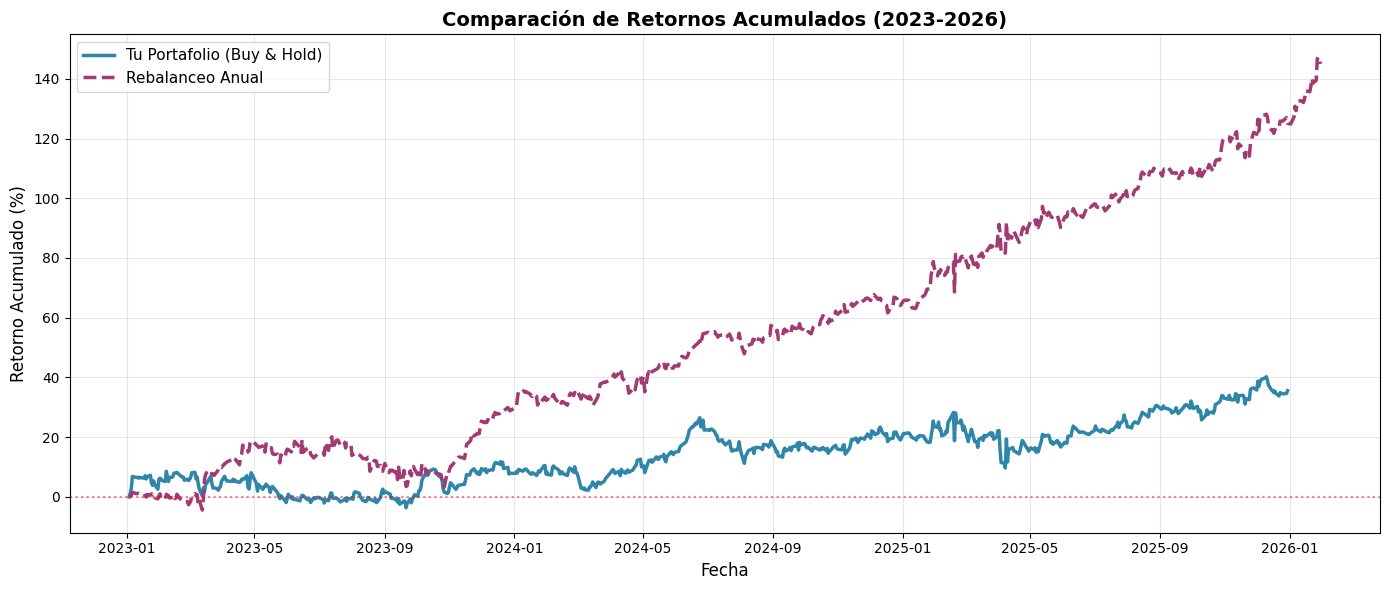


✅ Gráfico guardado como 'comparacion_retornos.png'


In [40]:
# Calcular valor del portafolio cada día
valor_portafolio = []

for i in range(len(precios)):
    valor_dia = 0
    for ticker, cantidad in portfolio_data.items():
        precio = precios.iloc[i][ticker]
        valor_dia += precio * cantidad
    valor_portafolio.append(valor_dia)

# Crear DataFrame con resultados
resultados_tu_portafolio = pd.DataFrame({
    'Valor_Portafolio': valor_portafolio
}, index=precios.index)

# Calcular retorno acumulado
inversion_inicial = valor_portafolio[0]
resultados_tu_portafolio['Retorno_Acumulado'] = (
    (resultados_tu_portafolio['Valor_Portafolio'] / inversion_inicial - 1) * 100
)

# COMPARACIÓN
print("="*80)
print("COMPARACIÓN DE RETORNOS ACUMULADOS")
print("="*80)

print(f"\nInversión Inicial: ${inversion_inicial:,.0f} COP")
print(f"\nValor Final Tu Portafolio: ${valor_portafolio[-1]:,.0f} COP")
print(f"Retorno Acumulado Tu Portafolio: {resultados_tu_portafolio['Retorno_Acumulado'].iloc[-1]:.2f}%")

print(f"\nValor Final Rebalanceo Anual: ${resultados_12m['Valor_Portafolio'].iloc[-1]:,.0f} COP")
print(f"Retorno Acumulado Rebalanceo Anual: {resultados_12m['Retorno_Acumulado'].iloc[-1]:.2f}%")

diferencia_retorno = resultados_12m['Retorno_Acumulado'].iloc[-1] - resultados_tu_portafolio['Retorno_Acumulado'].iloc[-1]
print(f"\nDiferencia: {diferencia_retorno:+.2f} puntos porcentuales")

if diferencia_retorno > 0:
    print(f"✅ El rebalanceo anual tuvo un retorno {abs(diferencia_retorno):.2f}% MAYOR")
else:
    print(f"✅ Tu portafolio tuvo un retorno {abs(diferencia_retorno):.2f}% MAYOR")

# GRÁFICO DE COMPARACIÓN
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(resultados_tu_portafolio.index, resultados_tu_portafolio['Retorno_Acumulado'], 
         label='Tu Portafolio (Buy & Hold)', linewidth=2.5, color='#2E86AB')
plt.plot(resultados_12m.index, resultados_12m['Retorno_Acumulado'], 
         label='Rebalanceo Anual', linewidth=2.5, color='#A23B72', linestyle='--')
plt.title('Comparación de Retornos Acumulados (2023-2026)', fontsize=14, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Retorno Acumulado (%)', fontsize=12)
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle=':', alpha=0.5)
plt.tight_layout()
plt.savefig('comparacion_retornos.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Gráfico guardado como 'comparacion_retornos.png'")